# Libraries

In [92]:
import os
import glob
import math
from typing import Any, Dict, List
from dataclasses import dataclass

from collections import defaultdict

from src.pipeline.dataloader import DataLoader, DataLoaderConfig
from src.pipeline.frame.filter import FrameFilters
from src.pipeline.frame.transformer import FrameTransformers
from src.pipeline.taskloader import TaskLoader, TaskFrame, TaskLoaderConfig
from src.pipeline.trainer import Trainer

from src.utils.parsers.cv_parser import to_cv_params, parse_cv_result
from src.utils.utils import TestResultStore

from src.settings.strategy import Strategy
from src.settings.tier import Tier

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from scipy.stats import pearsonr

from lime import lime_tabular
import shap


from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, GammaRegressor

from sklearn.metrics import mean_absolute_error

In [2]:
DataLoader.DATA_FOLDER = './data/training/'
dl = DataLoader()
tl = TaskLoader()

GRIDSEARCH_KWARGS = dict(
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score='raise',
)

shap.initjs()

# Model building

In [3]:
def get_generator(
    strategy:Strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER1,
    data_config: DataLoaderConfig = DataLoaderConfig(),
    task_config: TaskLoaderConfig = TaskLoaderConfig()
):
    df = dl.get_dataframe(data_config)
    gen = tl.prepare_task(df, tier).build(strategy, task_config)
    return gen

def build_model_pipeline(
    strategy:Strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER1
):
    tf = next(get_generator(
        strategy, tier
    ))
    
    numeric_features = ['enzyme_concentration'] + tf.x.columns.to_list()
    numeric_features = list(filter(lambda x: x in tf.x.columns.to_list(), numeric_features))
    numeric_transformer = Pipeline(
        steps=[
            ('scaler', StandardScaler())
        ]
    )

    cat_features = ['KO_ORF', 'ORF']
    cat_features = list(filter(lambda x: x in tf.x.index.names, cat_features))

    categorical_transformer = OneHotEncoder(
        categories=[
            y[cat].unique() for cat in cat_features if (y := tf.x.reset_index()) is not None
            # tf.x.reset_index()['KO_ORF'].unique(),
            # tf.x.reset_index()['ORF'].unique()
        ]
    )

    prepocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            # ('cat', categorical_transformer, cat_features),
        ],
        remainder='drop'
    )

    estimator = DecisionTreeRegressor()

    clf = Pipeline(
        steps=[
            ('preprocessor', prepocessor),
            # ('pca', PCA()),
            ('regressor', estimator),
        ]
    )

    model = TransformedTargetRegressor(
        regressor=clf,
        transformer=None,
    )
    return model



## Base data model (Tier 0)

In [4]:
EXPERIMENT_ID = 'experiment_0'
PATH_PREFIX = './data/results'
EXPERIMENT_PATH = f'{PATH_PREFIX}/{EXPERIMENT_ID}'
TIER = Tier.TIER0

if not os.path.exists(f'{EXPERIMENT_PATH}'):
    os.makedirs(f'{EXPERIMENT_PATH}')

config = DataLoaderConfig(
    additional_filters=[dl.data_factory.filters.is_precursor],
    additional_transforms=[dl.data_factory.transformer.log_fold_change_protein]
)

cv = RepeatedKFold(n_repeats=1, n_splits=10, random_state=0)

### Strategy All

In [6]:
STRATEGY = Strategy.ALL
SPLIT_KWARGS=dict(
    stratify='metabolite_id',
    shuffle=True
)
params = {
    'SVR': {
        'regressor__regressor': SVR(),
        'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        #'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    },
    'DecisionTreeRegressor': {
        'regressor__regressor': DecisionTreeRegressor(),
        'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
        'regressor__regressor__max_depth': [5, 10, 20, 15],
        #'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    },
    # 'GammaRegressor': {
    #     'regressor__regressor': GammaRegressor(),
    #     'regressor__regressor__alpha': [0, 1, 10],
    #     'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
    #     'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    # },
    'ElasticNet': {
        'regressor__regressor': ElasticNet(),
        'regressor__regressor__l1_ratio': [0.01, 0.25, 0.5, 0.75, 1],
        'regressor__regressor__tol': [0.01],
        #'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    }
}
trainer = Trainer()

#### Learning

In [6]:
model = build_model_pipeline(tier=TIER)
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    data_config=config
)
tf: TaskFrame = next(gen)

DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
DataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7fe79df049d0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7fe79df04700>>])


In [ ]:
search = trainer.do_grid_search(
    tf,
    model, 
    params,
    cv,
    split_kwargs=SPLIT_KWARGS,
    search_kwargs=GRIDSEARCH_KWARGS,
)

pd.DataFrame(search.cv_results_).to_csv(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')

In [7]:
results_df = pd.read_csv(f'{EXPERIMENT_PATH}/Strategy.ALL_all.csv')

model = build_model_pipeline(tier=Tier.TIER0)
model = parse_cv_result(model, results_df[results_df['rank_test_score'] == 1])
model = trainer.do_retrain_model(tf, model, split_kwargs=SPLIT_KWARGS)

_, X_test, _, y_test = trainer.do_train_test_split(tf, **SPLIT_KWARGS)

testResultStore = TestResultStore(EXPERIMENT_PATH, STRATEGY)
testResultStore.update_results(
    'all', model,
    X_test, y_test
)

for metabolite_id in X_test['metabolite_id'].unique():
    testResultStore.update_results(
        metabolite_id, 
        model,
        X_test[X_test['metabolite_id'] == metabolite_id], 
        y_test.xs(metabolite_id, level='metabolite_id')
    )

testResultStore.to_file()

DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
SVR model


#### Data throttle experiment

In [ ]:
for i in range(10, 110, 10):
    task_config = TaskLoaderConfig(data_throttle=i/100)

    model = build_model_pipeline(tier=TIER)
    gen = get_generator(
        strategy=STRATEGY,
        tier=TIER,
        data_config=config,
        task_config=task_config,
    )
    tf: TaskFrame = next(gen)

    search = do_grid_search(
        tf,
        model, 
        params,
        cv,
        split_kwargs=SPLIT_KWARGS
    )

    if not os.path.exists(f'{EXPERIMENT_PATH}/throttle/'):
        os.makedirs(f'{EXPERIMENT_PATH}/throttle')

    pd.DataFrame(search.cv_results_).to_csv(f'{EXPERIMENT_PATH}/throttle/{tf.title}_{tf.frame_name}_throttle{i/100}.csv')

In [ ]:
import gc

for i in range(10, 110, 10):
    gc.collect()
    for j in range(100):
        if not os.path.exists(EXPERIMENT_PATH + '/throttle/' + f"best_model_prediction_performance_{STRATEGY}_throttle{i/100}__run{j}.json"):
            # best_model_prediction_performance_Strategy.ALL_throttle0.2__run70
            print(f"{EXPERIMENT_PATH}/throttle/best_model_prediction_performance_{STRATEGY}_throttle{i/100}__run{j}.json")
            print(f"throttle: {i}  run: {j}")
            results_df = pd.read_csv(f'{EXPERIMENT_PATH}/throttle/Strategy.ALL_all_throttle{i/100}.csv')
            task_config = TaskLoaderConfig(data_throttle=i/100)

            gen = get_generator(
                strategy=STRATEGY,
                tier=TIER,
                data_config=config,
                task_config=task_config,
            )
            tf: TaskFrame = next(gen)

            model = build_model_pipeline(tier=TIER)
            model = parse_cv_result(model, results_df[results_df['rank_test_score'] == 1])
            model = do_retrain_model(tf, model, split_kwargs=SPLIT_KWARGS)

            _, X_test, _, y_test = do_train_test_split(tf, **SPLIT_KWARGS)
            print(X_test.shape)

            testResultStore = TestResultStore(EXPERIMENT_PATH + '/throttle/', f"{STRATEGY}_throttle{i/100}__run{j}")
            testResultStore.update_results(
                'all', model,
                X_test, y_test
            )

            for metabolite_id in X_test['metabolite_id'].unique():
                testResultStore.update_results(
                    metabolite_id, 
                    model,
                    X_test[X_test['metabolite_id'] == metabolite_id], 
                    y_test.xs(metabolite_id, level='metabolite_id')
                )

            testResultStore.to_file()

#### Explanation

In [7]:
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    data_config=config
)
tf: TaskFrame = next(gen)
results_df = pd.read_csv(f'{EXPERIMENT_PATH}/Strategy.ALL_all.csv')

model = build_model_pipeline(tier=TIER)
model = parse_cv_result(model, results_df[results_df['rank_test_score'] == 1])
model = trainer.do_retrain_model(tf, model, split_kwargs=SPLIT_KWARGS)

X_train, X_test, y_train, y_test = trainer.do_train_test_split(tf, **SPLIT_KWARGS)

selected_feature_names = model.regressor_[:-1].get_feature_names_out()
selected_feature_names

DataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f0580303700>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f0580303c10>>])
DataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])
SVR model


In [8]:
def apply_transform(X):
    _X = X
    for step in model.regressor_.steps[:-1]:
        _X = step[1].transform(_X)
    return _X

def apply_predict(X):
    return model.regressor_.named_steps['regressor'].predict(X)

In [10]:
def predict(x: np.array):
    _x = pd.DataFrame(
        np.append(np.zeros(shape=(x.shape[0], 2)), x, axis=1),
        columns=X_train.columns
    )
    return model.predict(_x)

In [ ]:
explanation_result = defaultdict(list)

_X_train = X_train[X_train.columns.difference(['KO_ORF', 'metabolite_id'])]
_X_test = X_test[X_test.columns.difference(['KO_ORF', 'metabolite_id'])]

explainer = lime_tabular.LimeTabularExplainer(
    _X_train.values, 
    feature_names=_X_train.columns, 
    verbose=True, 
    mode='regression',
    discretize_continuous=False
)

for i in range(len(X_test)):
    exp = explainer.explain_instance(_X_test.iloc[i], predict, num_features=10)
    explanation_result['KO_ORF'].append(X_test.iloc[i]['KO_ORF'])
    explanation_result['metabolite_id'].append(X_test.iloc[i]['metabolite_id'])
    explanation_result['exp_enzymes'].append([enzyme for enzyme, _ in exp.as_list()])
    explanation_result['exp_weights'].append([weight for _, weight in exp.as_list()])
    explanation_result['y_true'].append(exp.predicted_value)
    explanation_result['y_pred'].append(y_test.iloc[i])

pd.DataFrame.from_dict(explanation_result).to_json(f"{EXPERIMENT_PATH}/explanations/{STRATEGY}_explanation.json")

i = 2
exp = explainer.explain_instance(_X_test.iloc[i], predict, num_features=10)
print(y_test.iloc[i])
print(exp.as_list())
exp.show_in_notebook(show_table=True)

In [12]:
X_train_summary = shap.kmeans(apply_transform(X_train), 10)
ex = shap.KernelExplainer(apply_predict, X_train_summary)

In [25]:
shap_values = ex.shap_values(apply_transform(X_test.iloc[0,:].to_frame().T))
shap.force_plot(ex.expected_value, shap_values, apply_transform(X_test.iloc[0,:].to_frame().T))

  0%|          | 0/1 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


In [ ]:
shap_values = ex.shap_values(apply_transform(X_test), gc_collect=True)

In [71]:
X_test.iloc[0]

KO_ORF            YIL095W
metabolite_id         pyr
YAL003W          0.020398
YAL005C         -0.066505
YAL007C         -0.069201
                   ...   
YPR165W         -0.013347
YPR181C          0.001134
YPR183W          0.063487
YPR187W          0.363794
YPR191W         -0.080156
Name: 611, Length: 728, dtype: object

In [ ]:
idx = 0
sv = ex.shap_values(apply_transform(X_test))



In [132]:
exp = shap.Explanation(sv, np.array([ex.expected_value] * 222), data=apply_transform(X_test), feature_names=selected_feature_names)

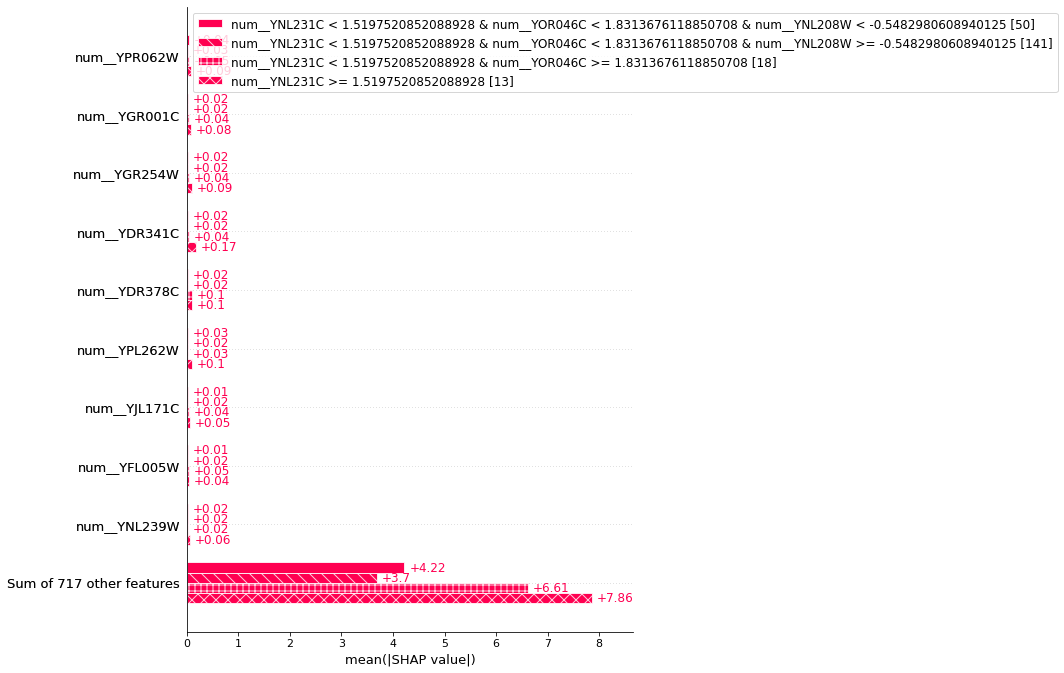

In [157]:
shap.plots.bar(exp.cohorts(4).abs.mean(0))

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
727it [52:11,  4.31s/it]                           


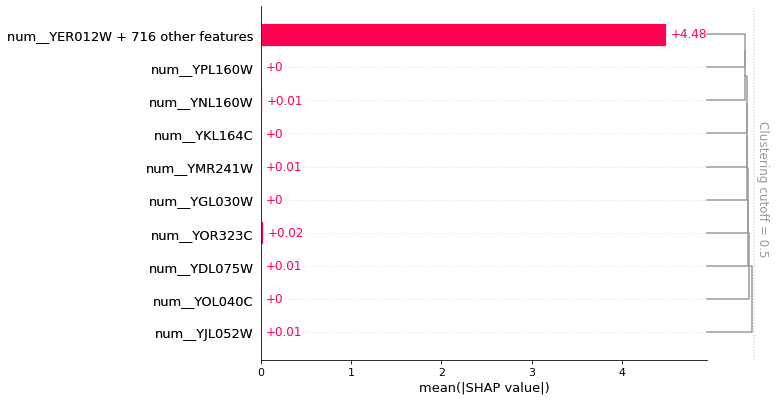

In [160]:
clustering = shap.utils.hclust(apply_transform(X_test), y_test) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(exp, clustering=clustering)

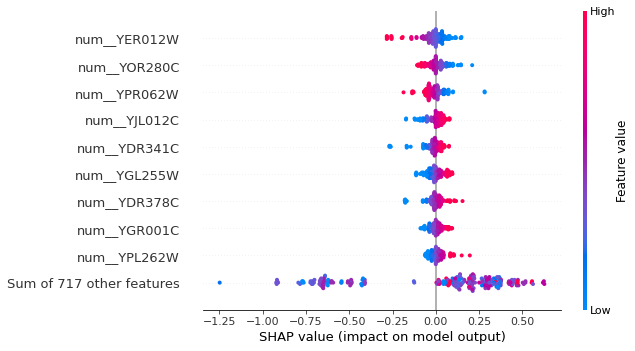

In [162]:
shap.plots.beeswarm(exp)

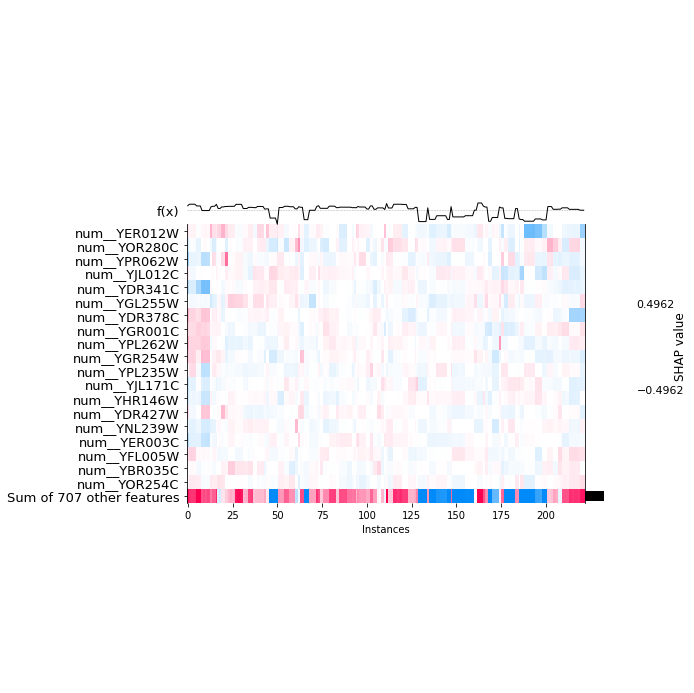

In [166]:
shap.plots.heatmap(exp, max_display=20)

In [161]:
shap.plots.bar(shap_values, clustering=clustering, cluster_threshold=0.9)

TypeError: bar() got an unexpected keyword argument 'cluster_threshold'

IndexError: tuple index out of range

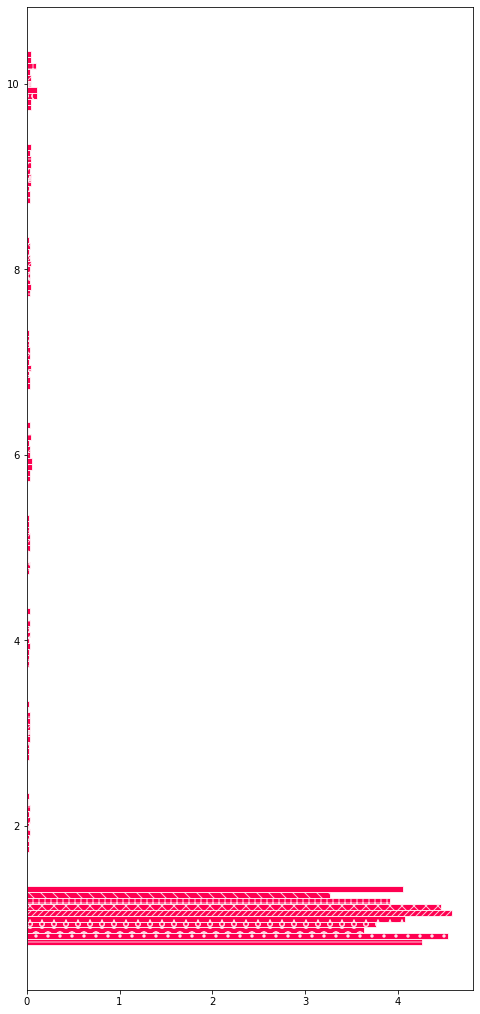

In [141]:
shap.plots.bar(exp.cohorts(X_test['metabolite_id'].values).abs.mean(0))

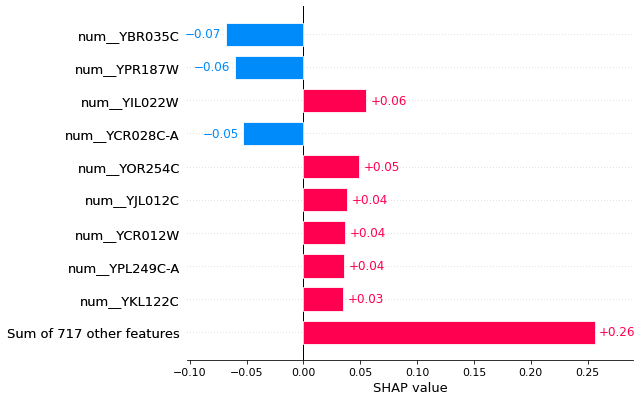

In [149]:
shap.plots.bar(exp[0])

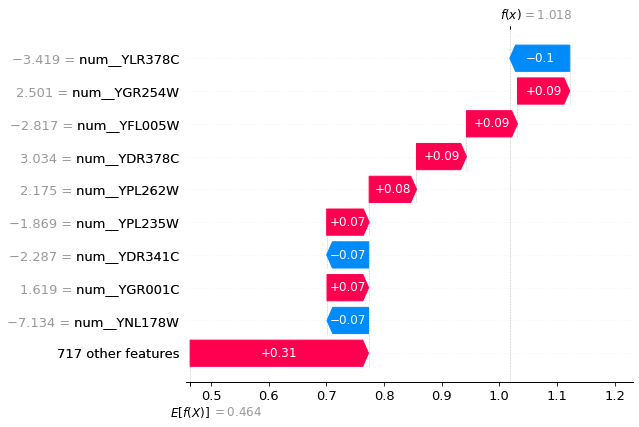

In [152]:
shap.plots.waterfall(exp[1])

In [84]:
shap.plots.bar(exp)

AttributeError: 'float' object has no attribute 'shape'

FixedFormatter should only be used together with FixedLocator


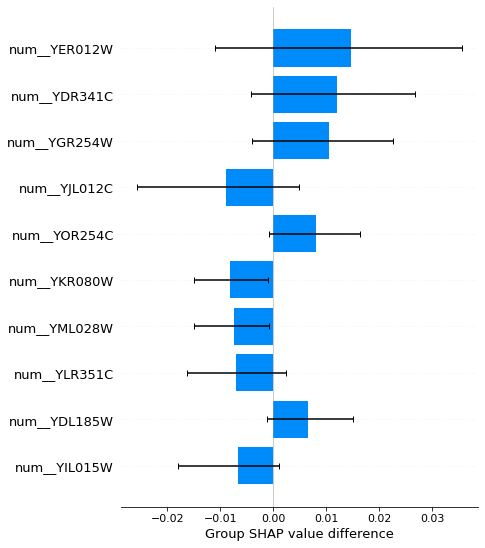

In [46]:
shap.group_difference_plot(
    shap_values,
    (X_test['metabolite_id']=='pyr').to_numpy(),
    feature_names=selected_feature_names,
    max_display=10
)

In [41]:
X_test['metabolite_id'] == 'pyr'

611     True
613     True
728    False
543    False
639     True
       ...  
309    False
134    False
320    False
722    False
174    False
Name: metabolite_id, Length: 222, dtype: bool

  0%|          | 0/29 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  3%|▎         | 1/29 [00:02<01:05,  2.34s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(

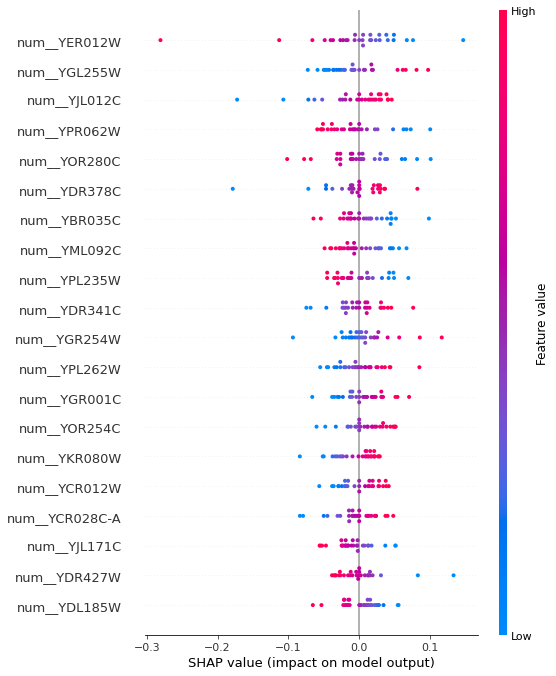

  0%|          | 0/29 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  3%|▎         | 1/29 [00:02<01:02,  2.23s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(

KeyboardInterrupt: 

In [36]:
for metabolite_id in X_test['metabolite_id'].unique():
    _X_test = X_test[X_test['metabolite_id'] == metabolite_id]
    shap_values = ex.shap_values(apply_transform(_X_test), gc_collect=True)
    shap.summary_plot(shap_values, apply_transform(_X_test), feature_names=selected_feature_names)
    


In [53]:
ex(apply_transform(X_test))

AttributeError: 'Kernel' object has no attribute 'masker'

In [ ]:
shap_values = ex.shap_values(apply_transform(X_test))

In [51]:
shap.waterfall_plot(shap_values)

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

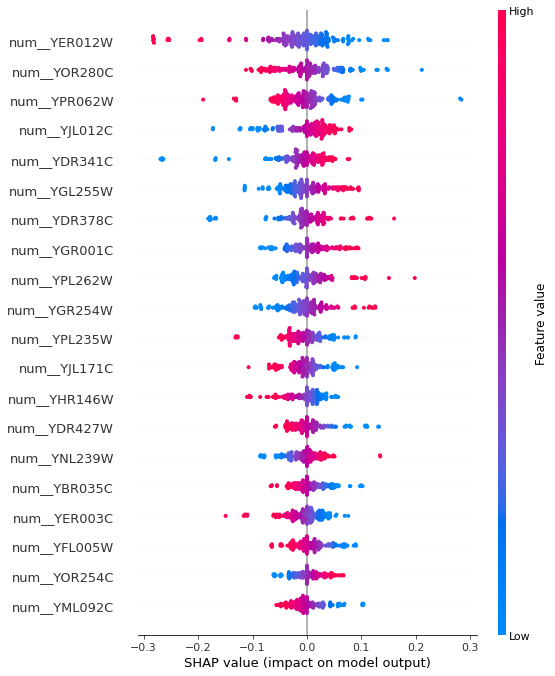

In [16]:
shap.summary_plot(shap_values, apply_transform(X_test), feature_names=selected_feature_names)

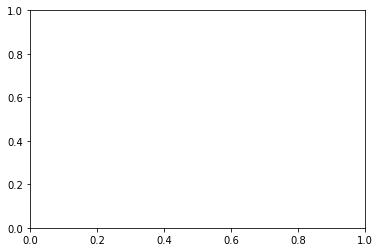

In [30]:
fig, ax = plt.subplots(1, 1)

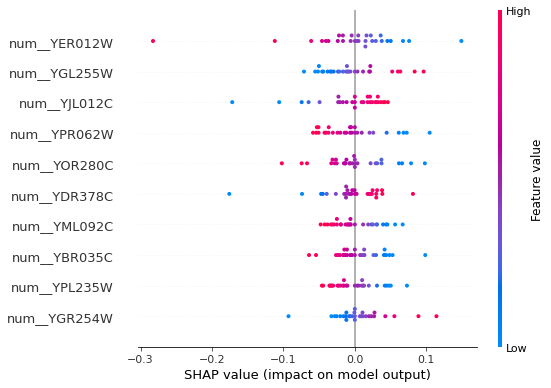

In [35]:
shap.summary_plot(shap_values, apply_transform(_X_test), feature_names=selected_feature_names, max_display=10)

In [27]:
ex.explain()

TypeError: explain() missing 1 required positional argument: 'incoming_instance'

In [ ]:
shap.force_plot(ex.expected_value, shap_values, apply_transform(X_test), selected_feature_names, 'test')

### Strategy metabolic centric

In [ ]:
STRATEGY = Strategy.METABOLITE_CENTRIC
SPLIT_KWARGS=dict(shuffle=False, stratify=None)
params = {
    'SVR': {
        'regressor__regressor': SVR(),
        'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    },
    'DecisionTreeRegressor': {
        'regressor__regressor': DecisionTreeRegressor(),
        'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
        'regressor__regressor__max_depth': [5, 10, 20, 15],
        'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    },
    # 'GammaRegressor': {
    #     'regressor__regressor': GammaRegressor(),
    #     'regressor__regressor__alpha': [0, 1, 10],
    #     'transformer': [MinMaxScaler()]
    # },
    'ElasticNet': {
        'regressor__regressor': ElasticNet(),
        'regressor__regressor__l1_ratio': [0.01, 0.25, 0.5, 0.75, 1],
        'regressor__regressor__tol': [0.01],
        'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    }
}

In [ ]:
model = build_model_pipeline(tier=TIER)
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    config=config
)

for tf in gen:
    # if not(os.path.exists(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')):
    search = do_grid_search(
        tf,
        model, 
        params,
        cv,
        split_kwargs=SPLIT_KWARGS
    )
    pd.DataFrame(search.cv_results_).to_csv(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')

    print("model score: %.3f" % search.score(X_test, y_test))
    print(search.best_params_)

In [ ]:
paths = glob.glob(EXPERIMENT_PATH + "/*.csv")

metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
results_df = pd.concat([
    pd.read_csv(path).assign(metabolite_id=metabolite_name) 
    for path, metabolite_name in zip(paths, metabolites_names)
])
results_df = results_df[(
    (results_df['param_regressor__regressor'].str.contains('DecisionTreeRegressor', na=False)) & \
    (results_df['param_regressor__regressor__max_depth'] > 0)
) | \
    (~results_df['param_regressor__regressor'].str.contains('DecisionTreeRegressor', na=False))
]

best_models = results_df[results_df.groupby(by='metabolite_id')['rank_test_score'].transform(min) == results_df['rank_test_score']]

In [ ]:
model = build_model_pipeline(tier=Tier.TIER0)
gen = get_generator(
    strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER0,
    config=config
)

testResultStore = TestResultStore(EXPERIMENT_PATH, STRATEGY)

for tf in gen:
    c_best_model = best_models[best_models['metabolite_id'] == tf.frame_name]
    model = parse_cv_result(model, c_best_model)
    model = do_retrain_model(tf, model, SPLIT_KWARGS)

    _, X_test, _, y_test = do_train_test_split(tf, **SPLIT_KWARGS)

    testResultStore.update_results(
        tf.frame_name,
        model,
        X_test,
        y_test
    )
        
testResultStore.to_file()

## Simple data model (Tier 1)

In [ ]:
EXPERIMENT_ID = 'experiment_1'
PATH_PREFIX = './data/results'
EXPERIMENT_PATH = f'{PATH_PREFIX}/{EXPERIMENT_ID}'
TIER = Tier.TIER1

if not os.path.exists(f'{EXPERIMENT_PATH}'):
    os.makedirs(f'{EXPERIMENT_PATH}')

config = DataLoaderConfig(
    additional_filters=[dl.data_factory.filters.is_precursor],
    additional_transforms=[dl.data_factory.transformer.log_fold_change_protein]
)

cv = RepeatedKFold(n_repeats=3, n_splits=10, random_state=0)

### Strategy ALL

In [ ]:
from sklearn.svm import LinearSVR

In [ ]:
STRATEGY = Strategy.ALL
SPLIT_KWARGS=dict(
    stratify='metabolite_id',
    shuffle=True
)
GRIDSEARCH_KWARGS = dict(
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score='raise',
)
params = {
    # 'SVR': {
    #     'regressor__regressor': SVR(),
    #     'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #     'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
    #     'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    # },
    # 'SVR': {
    #     'regressor__regressor': LinearSVR(),
    #     'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
    #     'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    # },
    'DecisionTreeRegressor': {
        'regressor__regressor': DecisionTreeRegressor(),
        'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
        'regressor__regressor__max_depth': [5, 10, 20, 15],
        'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    },
    # 'GammaRegressor': {
    #     'regressor__regressor': GammaRegressor(),
    #     'regressor__regressor__alpha': [0, 1, 10],
    #     'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
    #     'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    # },
    'ElasticNet': {
        'regressor__regressor': ElasticNet(),
        'regressor__regressor__l1_ratio': [0.01, 0.25, 0.5, 0.75, 1],
        'regressor__regressor__tol': [0.01],
        'regressor__pca__n_components': [0.1, 0.25, 0.5, 0.75, 0.99],
        'regressor__preprocessor__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    }
}

In [ ]:
model = build_model_pipeline(tier=TIER)
gen = get_generator(
    strategy=STRATEGY,
    tier=TIER,
    config=config
)
tf: TaskFrame = next(gen)

In [ ]:
search = do_grid_search(
    tf,
    model, 
    params,
    cv,
    split_kwargs=SPLIT_KWARGS,
    search_kwargs=GRIDSEARCH_KWARGS
)

pd.DataFrame(search.cv_results_).to_csv(f'{EXPERIMENT_PATH}/{tf.title}_{tf.frame_name}.csv')

In [ ]:
results_df = pd.read_csv(f'{EXPERIMENT_PATH}/Strategy.ALL_all.csv')

model = build_model_pipeline(tier=TIER)
model = parse_cv_result(model, results_df[results_df['rank_test_score'] == 1])
model = do_retrain_model(tf, model, split_kwargs=SPLIT_KWARGS)

_, X_test, _, y_test = do_train_test_split(tf, **SPLIT_KWARGS)

testResultStore = TestResultStore(EXPERIMENT_PATH, STRATEGY)
testResultStore.update_results(
    'all', model,
    X_test, y_test
)

for metabolite_id in X_test['metabolite_id'].unique():
    testResultStore.update_results(
        metabolite_id, 
        model,
        X_test[X_test['metabolite_id'] == metabolite_id], 
        y_test.xs(metabolite_id, level='metabolite_id')
    )

testResultStore.to_file()